# Monte Carlo Simulation



Using a Monte Carlo simulation find the probability distribution of the random variable $X$ which models the values obtained rolling two dice.

In [ ]:
import numpy as np

num_trials = 100000

sums = []
for _ in range(num_trials):
    rolls = np.random.randint(1, 7, size=2)
    total_sum = np.sum(rolls)
    sums.append(total_sum)

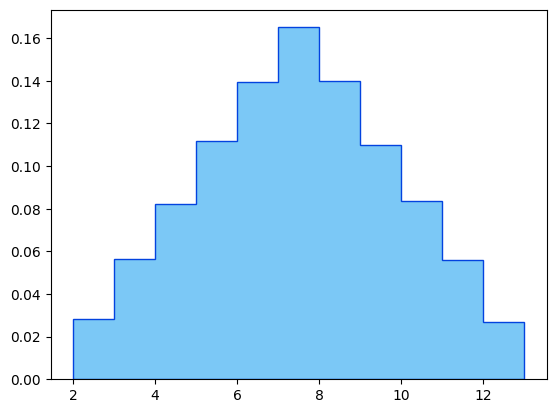

In [13]:
import matplotlib.pyplot as plt

plt.hist(sums, density=True, bins=11, range=(2, 13), histtype="stepfilled", color="xkcd:lightblue", edgecolor="xkcd:blue")
plt.show()

## Central Limit Theorem
The **Central Limit Theorem** states: *"the sampling distribution of the mean is normally distributed, as long as the sample size is large enough"*.
	
* the best estimate of a quantity given by MC experiments is the *mean* of the simulation results;
* with a larger sample size, your sample mean is more likely to be close to the population mean (more precise estimate).

(np.float64(6.990318), np.float64(0.10552485430456657))
(np.float64(6.98434), np.float64(0.35294980436317))
(np.float64(6.9935), np.float64(0.7577121815042965))


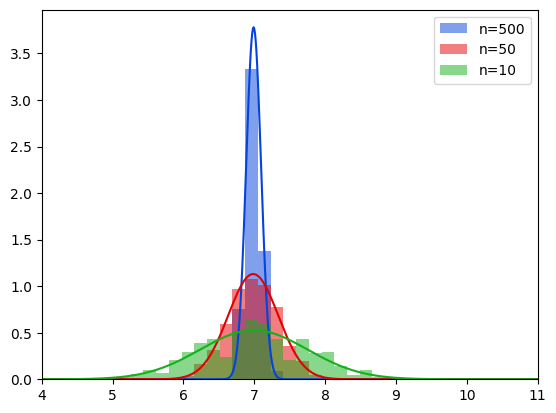

In [14]:
import numpy as np
from scipy.stats import norm

colors = ['xkcd:blue', 'xkcd:red', 'xkcd:green']

x = np.arange(4, 11, 0.01)
for i, size in enumerate(reversed([10, 50, 500])):
  sample_means = []
  for _ in range(1000):
    sample_means.append(np.mean(np.random.choice(sums, size=size)))
  plt.hist(sample_means, label=f"n={size}", bins=np.linspace(4, 11, 40), density=True, alpha=0.5, color=colors[i])
  N = norm.fit(sample_means)
  plt.plot(x, norm(*N).pdf(x), color=colors[i])
  print (N)
plt.xlim(4, 11)
plt.legend()
plt.show()

The resulting *improvement* can also be quantified:
\begin{equation}
    \cfrac{0.105}{0.353} = 0.30 \simeq \sqrt{\cfrac{50}{500}} = 0.31
\end{equation}
which tells us that **the uncertainty scales as the square root of the sample size**.

# Stochastic Process Simulation

## Brownian Motion
Brownian motion SDE is:
\begin{equation}
dW = \mathcal{N}(0, 1)\sqrt{dt}
\end{equation}

Hence the evolution in the interval $[t_0, T]$ is
\begin{equation}
W(T) = W_0 + \sum_{t=t_0}^{T}Z_t\sqrt{dt}
\end{equation}
where $Z_t$ represents the sampling from a Normal distribution at time $t$.


### Simulation of Brownian Motion

$\texttt{Python}$ is not that great when dealing with complex calculation; the trick that is usually used in these cases is to move to *linear algebra* using dedicated libraries which are highly optimized for such calculations (e.g. $\texttt{numpy}$).

The goal here is to simulate $N$ *realizations* of a Brownian motion (BM) process with $m$ *time steps* and initial value $W_0=0$. 

Instead of performing every single calculation for each time step and each realization, we are going to use matrices and perform bunch of operations at once.

Let's start with a $(N\times m)$ matrix $[W_0]$
$$
[W_0] =
    \begin{bmatrix}
    W^1_0 & W^2_0 & \cdots & W^N_0 \\
    0 & 0 & \cdots & 0 \\
    \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & \cdots & 0 \\
    \end{bmatrix}
$$

Then we calculate each variation by sampling $N\times (m-1)$ times from the Normal distribution and create a second matrix 
$$
[dW] =
    \begin{bmatrix}
    0 & 0 & \cdots & 0 \\
    dW^1_1 & dW^2_1 & \cdots & dW^N_1 \\
    \vdots & \vdots & \vdots & \vdots \\
    dW^1_{m} & dW^2_{m} & \cdots & dW^N_{m} \\
    \end{bmatrix}
$$  

Let's sum 
$$
[W] = [W_0] + [dW] =
    \begin{bmatrix}
    W^1_0 & W^2_0 & \cdots & W^N_0 \\
    dW^1_1 & dW^2_1 & \cdots & dW^N_1 \\
    \vdots & \vdots & \vdots & \vdots \\
    dW^1_{m} & dW^2_{m} & \cdots & dW^N_{m} \\
    \end{bmatrix}
$$  

Finally, we can obtain the Brownian motion evolution in each realization by simply summing up all the columns in $[W]$

$$
\left[
\begin{array}{cccc}
W^1_0 & W^2_0 & \cdots & W^N_0 \\
\downarrow & \downarrow & \cdots & \downarrow \\
dW^1_1 & dW^2_1 & \cdots & dW^N_1 \\
\downarrow & \downarrow & \vdots & \downarrow \\
dW^1_{m} & dW^2_{m} & \cdots & dW^N_{m} \\
\downarrow & \downarrow & \cdots & \downarrow \\
W^1_0+\sum\limits_{i=1}^{m} dW^1_i & W^2_0+\sum\limits_{i=1}^{m} dW^2_i & \cdots & W^N_0+\sum\limits_{i=1}^{m} dW^N_i
\end{array}\right]
$$

In [24]:
import numpy as np

N = 1000
m = 100
W0 = 0
dt = 1/m

W = np.zeros(shape=(m, N))
W[0, :] = W0
W[1:, :] = np.random.normal(size=(m-1, N))*np.sqrt(dt)
W = np.cumsum(W, axis=0)

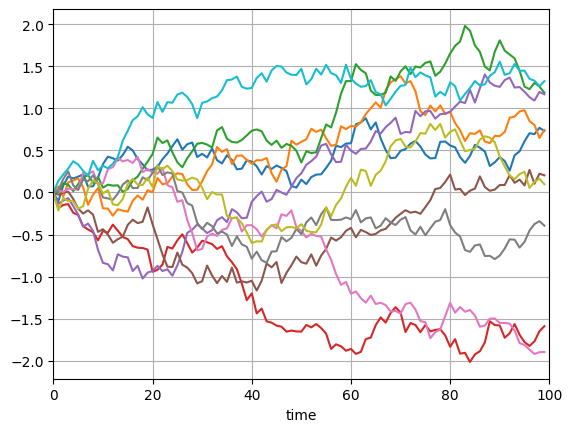

In [25]:
import matplotlib.pyplot as plt

for i in range(10):
  plt.plot(W[:, i], label=f"Real. {i}")
plt.grid(True)
plt.xlabel("time")
plt.xlim(0, 100)
#plt.legend()
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_stochastic_process_side_by_side(realizations, num_bins=30, bandwidth=0.1, right_width_ratio=0.2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6), sharey=False, gridspec_kw={'width_ratios': [1-right_width_ratio, right_width_ratio]})

    terminals = []
    time = np.arange(realizations.shape[0])
    for i in range(realizations.shape[1]):
        ax1.plot(time, realizations[:, i], marker='.', linestyle='-', markersize=4)
        terminals.append(realizations[-1, i])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$W$ Value")
    ax1.set_title("Geometric Brownian Motion Realizations")

    ax2.hist(terminals, bins=num_bins, orientation='horizontal', density=True, alpha=0.5,
             color='xkcd:lightblue', histtype="stepfilled", edgecolor="xkcd:blue", label='Histogram')

    params = stats.lognorm.fit(terminals)
    y_vals = np.linspace(min(terminals), max(terminals), 200)
    ax2.plot(stats.lognorm(*params).pdf(y_vals), y_vals, 'r-', label='KDE')

    plt.tight_layout()
    plt.show()



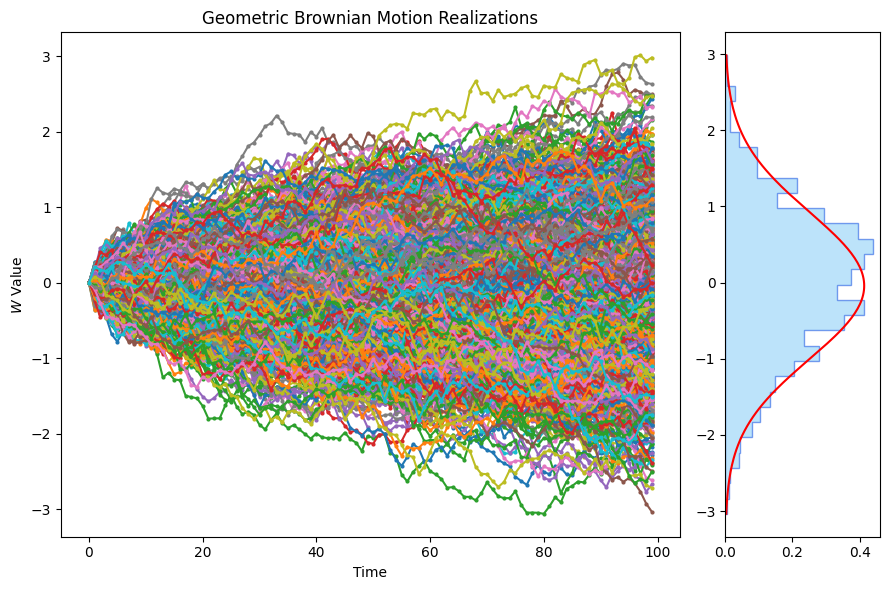

In [26]:
plot_stochastic_process_side_by_side(W)

## Geometric Brownian Motion

The **Geometric Brownian Motion** is characterized by the following SDE

$$dS = \mu S dt + \sigma S dW$$

with solution 

$$S(t_i) = S(t_{i-1})e^{(\mu-\frac{1}{2}\sigma^2)t+\sigma W_t}$$

It is usually used to model stock prices due to its striking feature of never becoming negative as prices do. The resulting paths are indeed distributed according to a log-normal distribution. 

Using the Euler scheme let's simulate the 4-months (with daily steps) evolution of a Geometric Brownian Motion stochastic process with initial value $S_0=100$, $\mu=0.005$, and $\sigma=0.05$.

In [27]:
import numpy as np

def GBM(mu, sigma, S0, T, tsteps, N):
    S = np.zeros(shape=(tsteps, N))
    dt = T/tsteps
    S[0, :] = S0
    dW = np.random.normal(size=(tsteps-1, N))*np.sqrt(dt)
    S[1:, :] = np.exp((mu-0.5*sigma**2)*dt+sigma*dW)
    return np.cumprod(S, axis=0)

In [28]:
np.random.seed(1)

S = GBM(0.005, 0.05, 100, 120, 120, 1)
Sdet = GBM(0.005, 0.0, 100, 120, 120, 1)

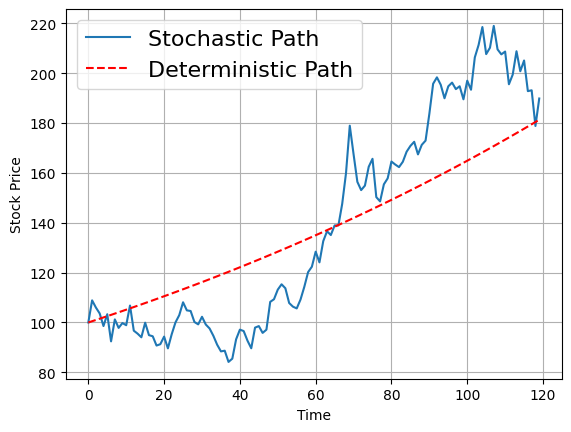

In [29]:
import matplotlib.pyplot as plt

plt.plot(S, label='Stochastic Path')
plt.plot(Sdet, linestyle='--', color='red', label='Deterministic Path')
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(fontsize='16')
plt.show()

In [30]:
np.random.seed(1)

S = GBM(0.005, 0.05, 100, 120, 120, 1000)

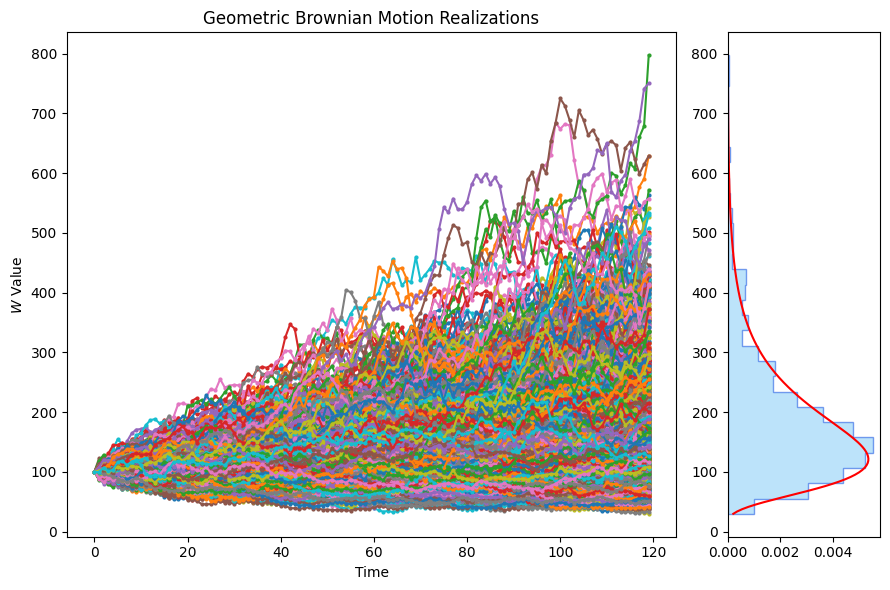

In [31]:
plot_stochastic_process_side_by_side(S)